In [2]:

import dataloader
import utilities
import transcribe
import madmom
import features
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

parameters = {
        "chroma_type":"crp",  # crp or dcp
        "vocabulary":"majmin",  # majmin, triads, triads_extended or majmin_sevenths
        "eval_scheme":"majmin",
        "source_separation":"None", # hprs, demucs or None
        "separation_type" : "harmonic+drums",  # harmonic, harmonic+drums, harmonic+vocals
        "prefilter":"rp", # None, "median" "rp"
        "embedding":25,
        "neighbours":50,
        "prefilter_length":7,  # N 
        "postfilter":"hmm", # None, "hmm" or "median"
        "transition_prob":0.3,  # 0..1
        "postfilter_length":1, # N
}

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"
output_path = "/home/max/ET-TI/Masterarbeit/results/"
results= []
print(f"Starting Transcription!")
for dataset_name in ["beatles","rwc_popular","queen","robbiewilliams"]:
    dataset = dataloader.Dataloader(dataset_name,base_path=PATH)
    print(f"Dataset: {dataset_name}")
    for fold in range(1,9):
        for track_id in tqdm(dataset.getExperimentSplits(fold),desc=f"fold {fold}/8"):            
            name = dataset.getTitle(track_id)
            audio_path,chords_path = dataset[track_id]
            ref_intervals,ref_labels = utilities.loadAnnotations(chords_path)

            ## Harmonic Percussive Source Separation ##
            try:
                if parameters.get("source_separation",False) == "hprs":
                    time_vector,signal = utilities.loadAudio(audio_path)
                    y_harm,y_perc,y_res = transcribe.harmonicPercussiveResidualSeparation(signal,beta=3,n_fft=4096)
                    signal = madmom.audio.signal.Signal(y_harm+y_res, sample_rate=signal.sample_rate, num_channels=1, start=signal.start, stop=signal.stop)
                elif parameters.get("source_separation",False) == "demucs":
                    time_vector,signal = utilities.loadAudio(audio_path,hpss=parameters.get("separation_type","harmonic"))
                else:
                    time_vector,signal = utilities.loadAudio(audio_path)
            except ValueError as e:
                print(e)
                continue
            ## Transcription ##
            if parameters.get("chroma_type","crp") == "dcp":
                # Transcribe with madmoms deep chroma processor and a conditional random field
                t_chroma,chroma = features.deepChroma(signal,split_nr=fold)
                est_intervals,est_labels = transcribe.transcribeDeepChroma(t_chroma,chroma)
            elif parameters.get("chroma_type","crp") == "crp":
                t_chroma,chroma = features.crpChroma(signal,nCRP=55,window=True,liftering=True)
                est_intervals, est_labels = transcribe.transcribeChromagram(t_chroma,chroma,**parameters)   
            
            ## Evaluation ##
            score,seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
            results.append((dataset_name,name,score,seg_score))
print(f"majmin songs with > 30%:")
majmin = [x[2] for x in results if x[2] > 0.3]
print(np.sum(majmin)/len(majmin))


Starting Transcription!
Dataset: beatles


fold 1/8:   0%|          | 0/23 [00:00<?, ?it/s]

fold 4/8:  82%|████████▏ | 18/22 [11:23<03:13, 48.33s/it]

In [8]:
#####   Save results ##########
import pickle

if parameters["chroma_type"] == "crp":
    dataObj = {'acrResults':results,'Params':parameters}
    file = open(f"/home/max/ET-TI/Masterarbeit/results/majmin_median_{parameters['prefilter_length']}_harmonic.obj","wb")
    pickle.dump(dataObj,file)
    file.close()


[('queen', '08 Save Me', 0.81, 0.91), ('queen', '10 Somebody To Love', 0.46, 0.74), ('queen', '16 We Will Rock You', 0.61, 0.26), ('queen', '15 Friends Will Be Friends', 0.77, 0.93), ('queen', '13 Play The Game', 0.71, 0.84), ('queen', '15 Seven Seas Of Rhye', 0.53, 0.68), ('queen', '09 Who Wants To Live Forever', 0.81, 0.86), ('queen', '05 Bicycle Race', 0.54, 0.66), ('queen', '12 Good Old-Fashioned Lover Boy', 0.44, 0.72), ('queen', '14 Hammer To Fall', 0.45, 0.4), ('queen', '02 Another One Bites The Dust', 0.01, 0.66), ('queen', "06 You're My Best Friend", 0.71, 0.58), ('queen', '17 We Are The Champions', 0.76, 0.83), ('queen', "07 Don't Stop Me Now", 0.79, 0.87), ('queen', '05 I Want To Break Free', 0.93, 0.91), ('queen', '04 Fat Bottomed Girls', 0.8, 0.71), ('queen', '09 Crazy Little Thing Called Love', 0.72, 0.76), ('queen', '04 I Want It All', 0.65, 0.77), ('queen', '01 Bohemian Rhapsody', 0.62, 0.76), ('queen', '01 A Kind Of Magic', 0.93, 0.89)]


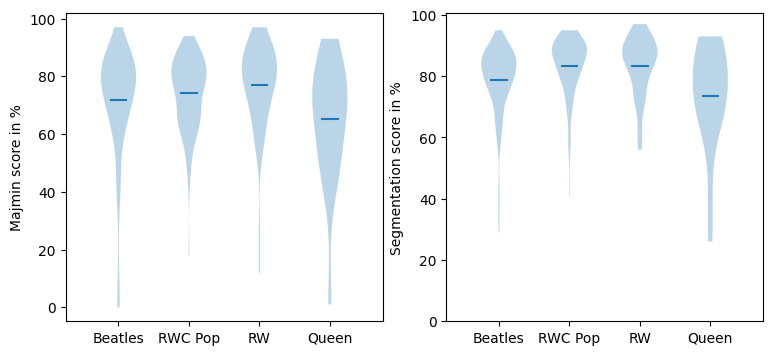

In [16]:
#### Load Results  ###########
file = open("/home/max/ET-TI/Masterarbeit/results/majmin_median_14_harmonic.obj",'rb')
dataObj = pickle.load(file)
file.close()

acrResults = dataObj["acrResults"]
params = dataObj["Params"]

# create Strings for textboxes
# retrieve parameters
image_path="/home/max/ET-TI/Masterarbeit/latex/figures/"
source_separation = params.get("source_separation","None")
prefilter = params.get("prefilter","None")
chroma_type = params.get("chroma_type","crp")

SAVE = False
if chroma_type == "dcp":
        parameterstring = f"DCP+CRF\nHPSS:\n{source_separation}"
else:
        if prefilter == "median":
                parameterstring = f"{chroma_type}\nHPSS:\n{source_separation}\nPrefilter:\nMedian N={params.get('prefilter_length',15)}\n\Postfilter:\nHMM p={params.get('transition_prob',0.3)}"
        elif prefilter == "rp":
                parameterstring = f"{chroma_type}\nHPSS:\n{source_separation}\nPrefilter:\nRP M={params.get('embedding',1)}, n={params.get('neighbours',10)}\nPostfilter:\nHMM p={parameters.get('transition_prob',0.3)}"
scorestring =  f"Majmin              {np.mean(np.array([x[2] for x in acrResults])):0.02f}\n"
scorestring += f"Segmentation   {np.mean(np.array([x[3] for x in acrResults])):0.02f}"

beatles_majmin= [100*x[2] for x in acrResults if x[0] == "beatles"]
rwc_majmin = [100*x[2] for x in acrResults if x[0] == "rwc_popular"]
rw_majmin = [100*x[2] for x in acrResults if x[0] == "robbiewilliams"]
queen_majmin = [100*x[2] for x in acrResults if x[0] == "queen"]

beatles_seg = [100*x[3] for x in acrResults if x[0] == "beatles"]
rwc_seg = [100*x[3] for x in acrResults if x[0] == "rwc_popular"]
rw_seg = [100*x[3] for x in acrResults if x[0] == "robbiewilliams"]
queen_seg = [100*x[3] for x in acrResults if x[0] == "queen"]

majmin = [beatles_majmin,rwc_majmin,rw_majmin,queen_majmin]
seg = [beatles_seg,rwc_seg,rw_seg,queen_seg]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.violinplot(majmin,showmeans=True, showmedians=False,
        showextrema=False)
ax2.violinplot(seg,showmeans=True, showmedians=False,
        showextrema=False)

labels = ["Beatles","RWC Pop","RW","Queen"]
ax1.set_yticks(np.arange(0,120,20))
ax1.set_ylabel("Majmin score in %")
ax1.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax1.set_xlim(0.25, len(labels) + 0.75)
ax2.set_yticks(np.arange(0,120,20))
ax2.set_ylabel("Segmentation score in %")
ax2.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax2.set_xlim(0.25, len(labels) + 0.75)

print([x for x in acrResults if x[0] == "queen"])

